# Classification d'images avec un réseau de neurones convolutif (CNN)

Dans ce notebook on se propose de classifier des images à partir d'un réseau de neurones en utilisant la bibliothèque pytorch.

## Travail demandé :


1. Implémentez un réseau de neurones convolutif avec l'architecture suivante : 
+ une couche de convolution avec activation ```reLU```, constituée de 32 convolutions $5\times 5$ (stride de $1\times1$). 
+ une couche de max pooling $2\times2$ (stride de $2\times2$)
+ une couche de convolution avec activation ```reLU```, constituée de 64 convolutions $5\times 5$ (stride de $1\times1$).
+ une couche de max pooling $2\times2$  (stride de $2\times2$).
+ une couche complètement connectée de 1024 neurones (activation ```reLU```).
+ la couche de sortie.

Toutes les couches sont avec un padding ```SAME```, c'est-à-dire que des zéros sont ajoutés en bordure d'image pour que les masques puissent également être appliqués sur ces bords.


2. Combien de paramètres possède ce réseau ? Justifiez en indiquant le calcul à effectuer pour trouver le résultat
3. Quelle performance obtenez-vous ?
4. Observez l'influence de différents paramètres sur la précision finale (nombre d'époques, taille de batch, taux d'apprentissage, etc.). Pour ces tests vous pourrez réduire le nombre d'exemples utilisés si les entrainements sont trop lents (notez que les comparaisons ne peuvent être faites que sur une même base de données et qu'il ne faudra donc pas faire varier ce nombre à chaque test)

### Imports python

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
%matplotlib inline

#Import pytorch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import torchvision
import torchvision.transforms as transforms


/home/thmegy/anaconda3/envs/m2par_torch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/thmegy/anaconda3/envs/m2par_torch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 1. Chargement et visualisation des données

On commence par charger nos données et les normaliser. Les données sont déjà séparées en une base d'entrainement et une base de test.

shape X train :  torch.Size([60000, 28, 28])
shape X test :  torch.Size([10000, 28, 28])
shape Y train :  torch.Size([60000])
shape Y test :  torch.Size([10000])


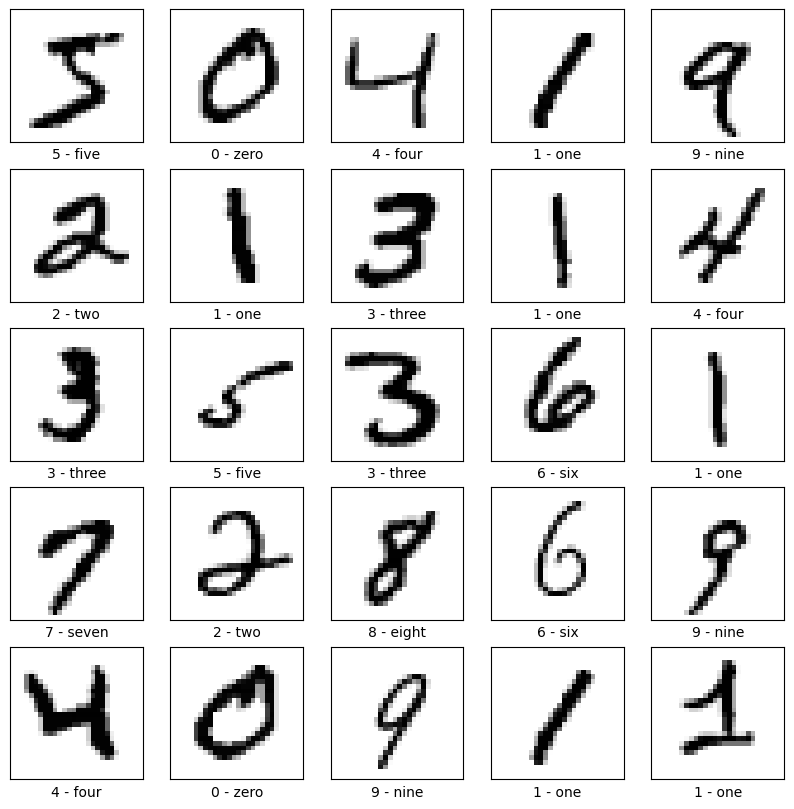

In [40]:
# Fonction de Normalisation pour passer de [0,255] vers [0,1]]
transform = transforms.Compose([transforms.ToTensor()])

# Dataset
mnistTrainSet = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnistTestSet = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = mnistTrainSet.data/255
X_test = mnistTestSet.data/255
Y_train = mnistTrainSet.targets
Y_test = mnistTestSet.targets
class_names = mnistTrainSet.classes

print('shape X train : ', X_train.shape)
print('shape X test : ', X_test.shape)
print('shape Y train : ', Y_train.shape)
print('shape Y test : ', Y_test.shape)

# Affichage de quelques images et label associé
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[Y_train[i]])

Pour utiliser moins d'images on complètera ici :

In [41]:
# Nombre d'exemples considérés (vous pouvez changer ici !) :
n_train = 1000

# Exemple de création d'un sous-ensemble du jeu d'entrainement
dataset_indices= list(range(len(mnistTrainSet)))
np.random.shuffle(dataset_indices)
subset_indices = dataset_indices[:n_train]
mnistTrainSubset = Subset(mnistTrainSet, subset_indices)

## 2. Construction du modèle 



### Modèle et prédictions

On définit notre réseau de neurones dans une classe spécifique ici. La fonction ```forward``` réalise notre propagation en avant, pour obtenir les probabilités prédites.

In [42]:
mp = nn.MaxPool2d(2, stride=2)
c = nn.Conv2d(1, 32, 5, padding='same')
c2 = nn.Conv2d(32, 64, 5, padding='same')
t = torch.randn(10,1,28,28)
mp(c2(mp(c(t)))).size()

torch.Size([10, 64, 7, 7])

In [43]:
# Classe qui définit le réseau :
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(7*7*64, 1024),
            nn.ReLU(),
            nn.Linear(1024,10),
            nn.Softmax(dim=1)
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
# Pour rendre les tirages aléatoires reproductibles (facultatif)   
torch.manual_seed(0)

# Création du réseau : 
model = convNet()

# Affichage de l'architecture :
print(model)

convNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=10, bias=True)
    (10): Softmax(dim=1)
  )
)


## 3. Entrainement

### Préparation à l'entrainement


In [44]:
# Hyperparamètres
N_epochs = 20
batch_size = 100
learning_rate = 0.01

#### Choix de la fonction de coût
https://pytorch.org/docs/master/nn.html#loss-functions

In [45]:
loss_function = nn.CrossEntropyLoss()

#### Choix de l'optimiseur
https://pytorch.org/docs/master/optim.html#algorithms

In [46]:
# Choix de l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

On sépare ici le Dataset de test en un ensemble de validation et un ensemble de test :

In [47]:
# Split test Dataset
mnistValset, mnistTestSet = random_split(mnistTestSet, 
                                                            [int(0.1 * len(mnistTestSet)), 
                                                             int(0.9 * len(mnistTestSet))])

# Outil de chargement des lots de données
mnistTrainLoader = DataLoader(mnistTrainSet, batch_size=batch_size,shuffle=True, num_workers=0)
mnistValLoader = DataLoader(mnistValset, batch_size=1000, shuffle=False, num_workers=0)
mnistTestLoader = DataLoader(mnistTestSet, batch_size=batch_size, shuffle=False, num_workers=0)

### Entrainement du réseau


In [48]:
# Nombre d'itérations
losses = []  
val_losses = []
i_list = []
i=0
for epoch in range(N_epochs):  # Boucle sur les époques   
    for features, labels in mnistTrainLoader:        
        
        #Propagation en avant
        pred = model(features)

        #Calcul du coût
        loss = loss_function(pred, labels)

        #on sauvegarde la loss pour affichage futur
        losses.append(loss.item())

        #Effacer les gradients précédents
        optimizer.zero_grad()        
        
        #Calcul des gradients (rétro-propagation)
        loss.backward()

        # Mise à jour des poids : un pas de l'optimiseur
        optimizer.step()
        
        i+=1
        
    with torch.no_grad():
        val_loss = []
        for features, labels in mnistValLoader:
            #Propagation en avant
            pred = model(features)

            #Calcul du coût
            loss = loss_function(pred, labels)

            #on sauvegarde la loss pour affichage futur
            val_loss.append(loss.item())
            
        val_losses.append(np.array(val_loss).mean())
        i_list.append(i)

        
    # print statistics
    print('[Epoque : %d] loss: %.3f' %
              (epoch + 1, loss.item()))
   
print('Entrainement terminé')

[Epoque : 1] loss: 2.349
[Epoque : 2] loss: 2.349
[Epoque : 3] loss: 2.349
[Epoque : 4] loss: 2.349


KeyboardInterrupt: 

In [ ]:
# Afficher l'évolution de la fonction de coût
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Fonction de cout')
axes.plot(val_losses,'b-',lw=2,label='Fonction de cout - validation')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Cout',fontsize=18)
plt.legend(loc='upper right',fontsize=16)

## 5. Evaluation des performances

In [ ]:
correct = 0
total = 0
# Pas besoin de calculer les gradient ici puisqu'on n'optimise plus
with torch.no_grad():
    for data in mnistTestLoader:
        images, labels = data
        # Propagation en avant pour calculer les prédictions
        outputs = model(images)         
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy sur les 10000 images de test : %d %%' % (
    100 * correct / total))

## 6. Predictions

In [ ]:
predictions = model(X_test.type(torch.FloatTensor))
print('shape predictions : ', predictions.shape)


In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = F.softmax(predictions_array[i]), true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])  
    plt.imshow(img, cmap=plt.cm.binary)  
    predicted_label = torch.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*torch.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = F.softmax(predictions_array[i]), true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array.detach(), color="#777777")
    plt.ylim([0, 1])
    predicted_label = torch.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


# Affichage de quelques images et de leurs prédictions 
_, predicted = torch.max(predictions.data, 1)
labels = Y_test
correct = (predicted == labels)
false = (predicted != labels)
    
# Affichage de quelques exemples d'erreurs
idx_false = np.where(false)
plt.figure(figsize=(18,12))
K=0
for i in idx_false[0][0:12]:  
    plt.subplot(4,6,2*K+1)
    plot_image(i, predictions, Y_test, X_test)
    plt.subplot(4,6,2*K+2)
    plot_value_array(i, predictions,  Y_test)
    plt.xlabel(class_names[Y_test[i]])
    K=K+1
plt.show()


# Affichage de quelques exemples de prédictions correctes
idx_correct = np.where(correct)
plt.figure(figsize=(18,12))
K=0
for i in idx_correct[0][0:12]:  
    plt.subplot(4,6,2*K+1)
    plot_image(i, predictions, Y_test, X_test)
    plt.subplot(4,6,2*K+2)
    plot_value_array(i, predictions,  Y_test)
    plt.xlabel(class_names[Y_test[i]])
    K=K+1
plt.show()